# Data & Library import

In [675]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

In [695]:
data = pd.read_csv("dataset.csv",delimiter=';')
data.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Mother's occupation,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,8,5,2,1,1,1,13,10,6,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,6,1,11,1,1,1,1,3,4,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,5,1,1,1,22,27,10,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,8,2,15,1,1,1,23,27,6,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,12,1,3,0,1,1,22,28,10,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


# Data Pre-Processing

Choosing best feature

In [696]:
# fix label name
data = data.rename({'Nactionality':'Nationality'})

In [697]:
# run only once
le = preprocessing.LabelEncoder()
data["Target"] = le.fit_transform(data["Target"])
# 0 : Drop out 
# 1 : Enrolled
# 2 : Graduate

In [703]:
features = data.drop(columns=["Target"])
target = data.Target
num_features = 10

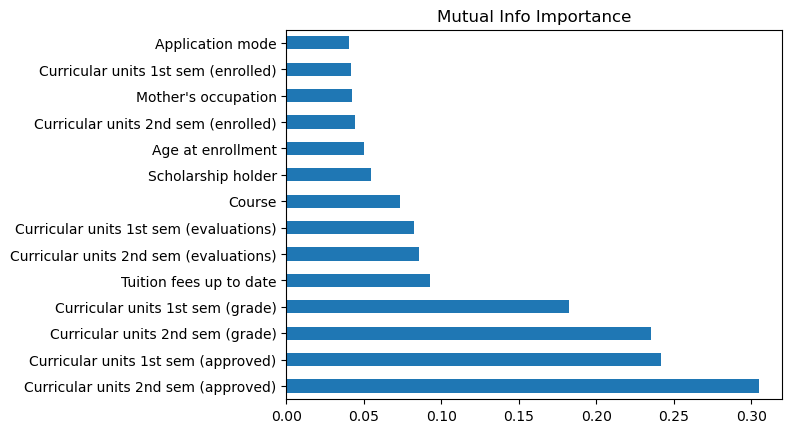

In [782]:
importance = mutual_info_classif(features,target)
ft_imp = pd.Series(importance, index=features.columns)
largest = ft_imp.nlargest(num_features).index
feature_select = features[largest]
ft_imp.nlargest(num_features).plot(kind="barh")
plt.title("Mutual Info Importance")
plt.show()

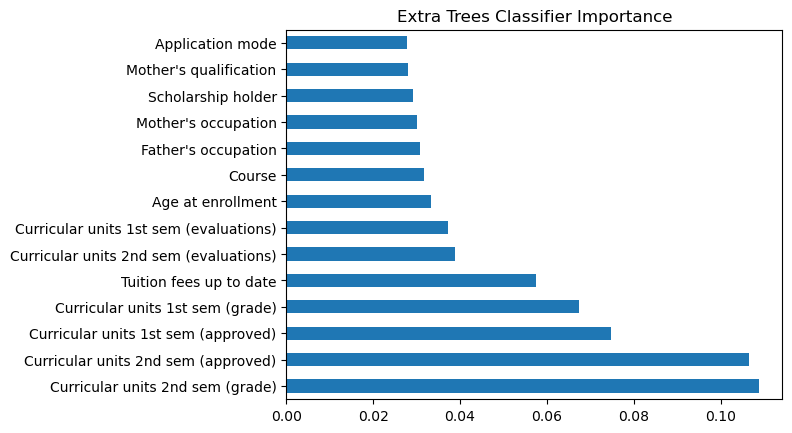

In [762]:
model = ExtraTreesClassifier()
model.fit(features,target)
ft_imp = pd.Series(model.feature_importances_, index=features.columns)
largest = ft_imp.nlargest(num_features).index
feature_select = features[largest]
ft_imp.nlargest(num_features).plot(kind="barh")
plt.title("Extra Trees Classifier Importance")
plt.show()

In [783]:
categorical_labels = ['Marital status', 'Application mode', 'Application order', 'Course',
       'Daytime/evening attendance', 'Previous qualification', 'Nacionality',
       'Mother\'s qualification', 'Father\'s qualification',
       'Mother\'s occupation', 'Father\'s occupation', 'Displaced',
       'Educational special needs', 'Debtor', 'Tuition fees up to date',
       'Gender', 'Scholarship holder']

In [784]:
categorical_labels_filter = list(set(categorical_labels).intersection(largest))
one_hot = pd.get_dummies(feature_select,columns=categorical_labels_filter)

Turning data into tensor

In [785]:
test_size = 0.33

X_train, X_test, y_train, y_test = train_test_split(
  one_hot, target, test_size=test_size)


In [786]:
X_train_np = X_train.values
X_test_np = X_test.values
y_train_np = y_train.values
y_test_np = y_test.values

In [787]:
class Data(Dataset):
  def __init__(self, X_train, y_train):
    # need to convert float64 to float32 else 
    # will get the following error
    # RuntimeError: expected scalar type Double but found Float
    self.X = torch.from_numpy(X_train.astype(np.float32))
    # need to convert float64 to Long else 
    # will get the following error
    # RuntimeError: expected scalar type Long but found Float
    self.y = torch.from_numpy(y_train).type(torch.LongTensor)
    self.len = self.X.shape[0]
  
  def __getitem__(self, index):
    return self.X[index], self.y[index]
  def __len__(self):
    return self.len

In [788]:
traindata = Data(X_train_np,y_train_np)

In [789]:
batch_size = 500
trainloader = DataLoader(traindata, batch_size=batch_size, 
                         shuffle=True, num_workers=0)

In [790]:
input_dim = len(one_hot.columns)
output_dim = 3
hidden = (input_dim + output_dim) // 2

In [791]:
class Network(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear1 = nn.Linear(input_dim,hidden)
    self.linear2 = nn.Linear(hidden,output_dim)

  def forward(self, x):
    x = torch.relu(self.linear1(x))
    x = self.linear2(x)
    return x

In [792]:
clf = Network()
print(clf.parameters)

<bound method Module.parameters of Network(
  (linear1): Linear(in_features=80, out_features=41, bias=True)
  (linear2): Linear(in_features=41, out_features=3, bias=True)
)>


In [793]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(clf.parameters(), lr=0.001)

# Training

In [794]:
epochs = 1000
loss_arr = [i for i in range(epochs)]
for epoch in range(epochs):
  running_loss = 0.0
  for i, data in enumerate(trainloader, 0):
    inputs, labels = data
    optimizer.zero_grad() # set optimizer to zero grad to remove previous epoch gradients
    outputs = clf(inputs) # forward propagation
    loss = criterion(outputs, labels)
    loss.backward() # backward propagation
    optimizer.step() # optimize
    running_loss += loss.item()
  # display statistics
  if epoch % 100 == 0:
    print(f'epoch: {epoch}, loss: {running_loss}')
  loss_arr[epoch] = running_loss

epoch: 0, loss: 7.336774826049805
epoch: 100, loss: 4.599019646644592
epoch: 200, loss: 4.29769903421402
epoch: 300, loss: 4.1313294768333435
epoch: 400, loss: 4.025587022304535
epoch: 500, loss: 3.9462886452674866
epoch: 600, loss: 3.886346697807312
epoch: 700, loss: 3.8389071822166443
epoch: 800, loss: 3.8002238869667053
epoch: 900, loss: 3.76621013879776


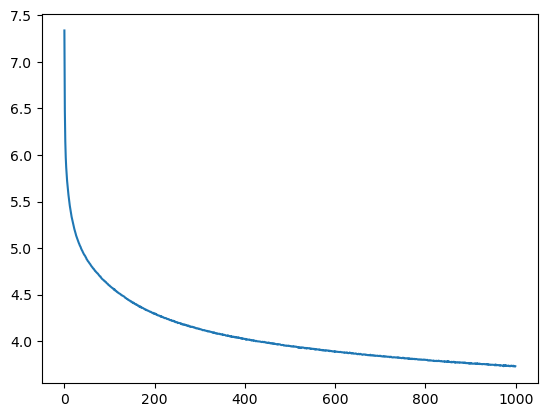

In [795]:
plt.plot(loss_arr)

# Testing

In [796]:
testdata = Data(X_test_np, y_test_np)
testloader = DataLoader(testdata,batch_size=testdata.len,
                        shuffle=True, num_workers=0)

In [797]:
dataiter = iter(testloader)
inputs, labels = next(dataiter)

In [798]:
outputs = clf(testdata.X)
__, predicted = torch.max(outputs, 1)

In [799]:
print(predicted)

tensor([2, 2, 2,  ..., 0, 1, 2])


In [800]:
print(accuracy_score(predicted,testdata.y))

0.7589041095890411


In [781]:
rand_predictions = np.random.randint(0,3,size=testdata.len)
print(accuracy_score(rand_predictions,testdata.y))

0.3232876712328767


___
# WONJOONCHOI

In [317]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.neural_network import MLPClassifier

# Data Preprocessing

In [318]:
data = pd.read_csv('dataset.csv', delimiter=';')
number_of_pairs = data.index.stop

In [319]:
le = preprocessing.LabelEncoder()
data["Target"] = le.fit_transform(data["Target"])
# 0 : Drop out 
# 1 : Enrolled
# 2 : Graduate

In [320]:
feature = data.drop(columns=["Target"])
target = data.Target

In [321]:
input_patterns = []
for i in range(number_of_pairs):
    input_patterns.append(feature.iloc[i].to_list())

In [322]:
X_train, X_test, y_train, y_test = train_test_split(input_patterns,target)

# Define Helper Functions 

In [337]:
def plot_confusion_matrix(matrix,title=""): 
    #put the heatmap into the figure 
    sns.heatmap(data=matrix, annot=True, cmap="crest")
    status=["Drop-out","Enrolled","Graduate"]
    axis_ticks=np.arange(len(status))+0.4
    
    #sets x axis ticks to species names
    plt.xticks(axis_ticks,status) 
    
    #sets y axis ticks to species names 
    plt.yticks(axis_ticks,status) 
    plt.title(title)
    plt.ylabel("Actual Label")
    plt.xlabel("Predicted Label")

In [338]:
def find_best_depth(model): 
    # Max Depth iteration
    N = 30
    # set initial list length of N
    scores = np.zeros(N)
    best_score = -np.inf
    for d in range(1,N+1):
                # set model with random state
        ref = model(max_depth=d,random_state=1111)
        # calculate score
        scores[d-1] = cross_val_score(ref,X_train,y_train,cv=5).mean() 
        if scores[d-1] >best_score:
                # update best_score and best_depth
                best_score=scores[d-1]
                best_depth = d
        # plot scatter plot
    fig, ax = plt.subplots(1) 
    ax.scatter(np.arange(1,N+1),scores)
    ax.set(title="Best Depth: " + str(best_depth)) 
    return best_depth

# CNN 

In [339]:
nn = MLPClassifier(hidden_layer_sizes = (100),
                   activation = "relu", # Activation function for the hidden layer.
                   solver = "adam", # The solver for weight optimization.
                   alpha = 0.0001, # Strength of the L2 regularization term.
                   batch_size = 'auto',# Size of minibatches for stochastic optimizers.
                   learning_rate_init = 0.001, 
                   max_iter = 500,
                   shuffle = True,# shuffle samples in each iteration
                   random_state = 0,
                   verbose = True) # Allows to print progress messages to stdout.

nn.fit(X_train, y_train)

ValueError: Found input variables with inconsistent numbers of samples: [2964, 3318]

In [340]:
nn.score(X_test,y_test)

AttributeError: 'MLPClassifier' object has no attribute 'n_layers_'

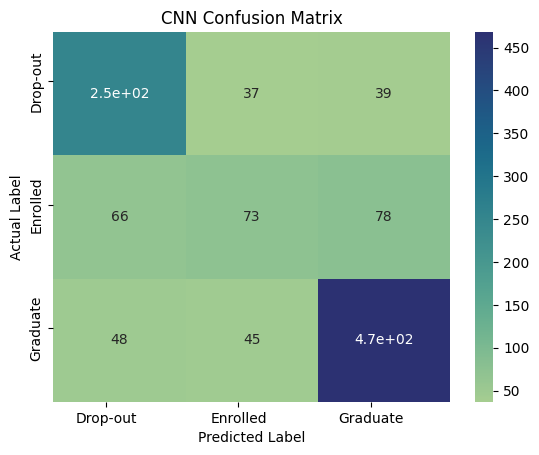

In [14]:
y_train_pred = nn.predict(X_test)
cnn_matrix = confusion_matrix(y_test,y_train_pred)
plot_confusion_matrix(cnn_matrix, title="CNN Confusion Matrix")

# Random Forest Classifier

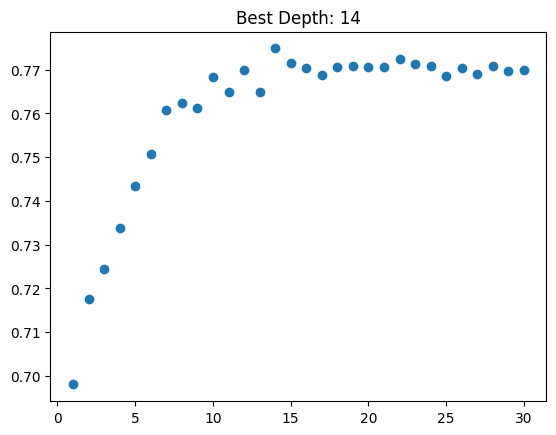

In [15]:
best_depth = find_best_depth(RandomForestClassifier)

In [16]:
RF = RandomForestClassifier(max_depth=best_depth,random_state=1111)
RF.fit(X_train,y_train)

y_train_pred = RF.predict(X_test)
RF_matrix = confusion_matrix(y_test,y_train_pred)

In [17]:
RF.score(X_test,y_test)

0.7757685352622061

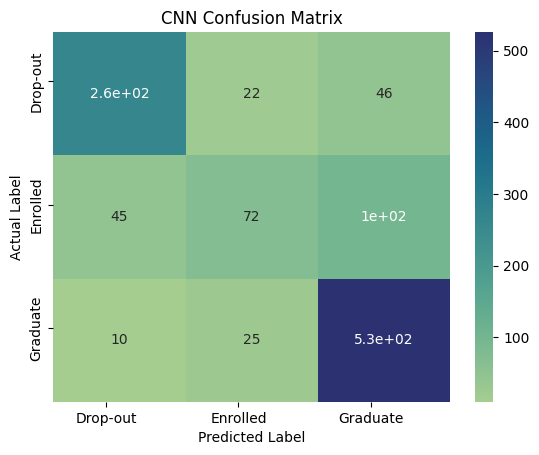

In [18]:
plot_confusion_matrix(RF_matrix,title="CNN Confusion Matrix")